In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from matplotlib import pyplot as plt

import pygal.maps.fr

## Extraction des données
### Données électorales

In [2]:
fichiers = os.listdir("clean")
print(fichiers)
data = {}
for fichier in fichiers:
    data[fichier[:-10]] = pd.read_csv("clean/"+fichier)

['dep15_clean.csv', 'dep20_clean.csv', 'eur14_clean.csv', 'eur19_clean.csv', 'leg12_clean.csv', 'leg17_clean.csv', 'mun14_clean.csv', 'mun20_clean.csv', 'pdt12_clean.csv', 'pdt17_clean.csv', 'reg15_clean.csv', 'reg21_clean.csv']


In [3]:
data.keys()

dict_keys(['dep15', 'dep20', 'eur14', 'eur19', 'leg12', 'leg17', 'mun14', 'mun20', 'pdt12', 'pdt17', 'reg15', 'reg21'])

In [4]:
data["mun14"]

,Code du département,Votants,A,C,D,ED,EG,G,ABN
0,1,187921,25107,1704,97220,1407,646,47379,143886
1,2,130617,16806,2206,42548,8648,3461,45240,100498
2,3,117014,639,900,52233,2172,7299,46549,69755
3,4,60479,0,1325,25335,4648,3251,22289,30051
4,5,45731,1358,0,23817,0,2312,15150,25831
...,...,...,...,...,...,...,...,...,...
98,974,398196,15334,51185,164553,3612,20466,126892,223379
99,975,3065,0,0,0,0,0,2826,1619
100,976,49839,1752,1522,18319,418,0,26676,24922
101,987,90709,6471,0,59321,0,0,23636,53508


In [5]:
# Ajout pour chaque df de l'information type d'élection (trois lettres)
# et année (quatre chiffres)
for df in data.keys():
    elec = df[0:3]
    annee = "20"+df[3:]
    data[df]["election"]=elec
    data[df]["annee"]=str(annee)
    data[df] = data[df].replace(r"^([0-9])$", "0"+r"\1")
data["leg12"]

,Code du département,Votants,ABN,EG,G,C,D,ED,A,election,annee
0,1,229340,167519,11585.0,81736.0,1418.0,91839.0,40097.0,NaN,leg,2012
1,2,221695,157597,17455.0,89223.0,11920.0,59159.0,40811.0,NaN,leg,2012
2,3,156407,102631,20525.0,64538.0,866.0,50660.0,16903.0,NaN,leg,2012
3,4,77302,47929,7968.0,32173.0,1909.0,21855.0,12075.0,NaN,leg,2012
4,5,66340,41817,5311.0,30581.0,630.0,20184.0,8125.0,277.0,leg,2012
...,...,...,...,...,...,...,...,...,...,...,...
102,987,85547,102831,104.0,4237.0,2548.0,53999.0,327.0,22771.0,leg,2012
103,975,2636,2371,NaN,1674.0,NaN,765.0,116.0,NaN,leg,2012
104,986,7012,2046,NaN,4079.0,858.0,1997.0,NaN,NaN,leg,2012
105,971,6835,16115,NaN,2802.0,NaN,3505.0,312.0,NaN,leg,2012


### Données de population par département et par année

In [6]:
years = [str(i) for i in range(2011,2022)]

In [7]:
popu = pd.read_excel("pop_raw.xlsx", sheet_name=years, skiprows=4, usecols="A,B,H")
for year in years:
    popu[year].columns = ["Code du département", "Nom", "Population"]
    popu[year]["annee"]=str(year)
    popu[year].dropna(subset=['Code du département'], inplace=True)
    popu[year].dropna(subset=['Nom'], inplace=True)
    popu[year].drop(columns=["Nom"],inplace=True)
    popu[year][["Code du département", "annee"]] = popu[year][["Code du département", "annee"]].astype(str)
popu['2012'].head()

,Code du département,Population,annee
0,01,612191.0,2012
1,02,540888.0,2012
2,03,342911.0,2012
3,04,161241.0,2012
4,05,139554.0,2012


In [8]:
# concaténation de toutes les données démographiques pour toutes les années
pop = pd.concat(popu.values())

In [9]:
#Uniformisation des codes de départements
depdict = {"ZA": "971", 
            "ZB": "972", 
            "ZC": "973", 
            "ZD": "974", 
            "ZS": "975", 
            "ZP": "987", 
            "ZN": "988", 
            "ZM": "976",
            "ZW": "986",
            "ZX": "978",
            "ZZ": "99",
            "1":"01",
            "2":"02",
            "3":"03",
            "4":"04",
            "5":"05",
            "6":"06",
            "7":"07",
            "8":"08",
            "9":"09"}

pop = pop.replace(depdict)

In [10]:
#Ajout d'une ligne pour l'ensemble de la corse (population 20 = 2A + 2B)
for year in years:
    a = pop["Population"].loc[(pop["Code du département"]=="2A") & (pop["annee"]==year)].values[0]
    b = pop["Population"].loc[(pop["Code du département"]=="2B") & (pop["annee"]==year)].values[0]
    pop = pop.append({'Code du département' : '20' , 'annee' : year, 'Population' : a+b}, 
                     ignore_index=True)

### Evolution démographique par département et par année

In [11]:
diff_pop = pop.pivot(index='Code du département', columns='annee')['Population'].copy()
diff_pop.head()

annee,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Code du département,,,,,,,,,,,
01,603827.0,612191.0,619497.0,626127.0,631877.0,638425.0,643350.0,647634.0,652860.0,657907.0,662244.0
02,541302.0,540888.0,540067.0,539783.0,538659.0,536136.0,534490.0,533316.0,530985.0,528471.0,525503.0
03,342729.0,342911.0,343431.0,343062.0,341613.0,339384.0,337988.0,337171.0,335537.0,333847.0,331745.0
04,160959.0,161241.0,161916.0,161588.0,161799.0,162565.0,163915.0,164068.0,164663.0,165232.0,165702.0
05,138605.0,139554.0,139279.0,139883.0,140916.0,141107.0,141284.0,140698.0,140557.0,140349.0,140022.0


In [12]:
#chaque colonne contient l' "évolution démographique" : pop(année i)-pop(i-1)
n=len(years)
for i in range(n-1,0,-1):
    diff_pop[years[i]] = diff_pop[years[i]] - diff_pop[years[i-1]]
diff_pop.drop(["2011"],axis=1, inplace=True)

diff_pop.head()

annee,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Code du département,,,,,,,,,,
01,8364.0,7306.0,6630.0,5750.0,6548.0,4925.0,4284.0,5226.0,5047.0,4337.0
02,-414.0,-821.0,-284.0,-1124.0,-2523.0,-1646.0,-1174.0,-2331.0,-2514.0,-2968.0
03,182.0,520.0,-369.0,-1449.0,-2229.0,-1396.0,-817.0,-1634.0,-1690.0,-2102.0
04,282.0,675.0,-328.0,211.0,766.0,1350.0,153.0,595.0,569.0,470.0
05,949.0,-275.0,604.0,1033.0,191.0,177.0,-586.0,-141.0,-208.0,-327.0


In [13]:
# Repasser les années sur une seule colonne
diff_pop = pd.melt(diff_pop.reset_index(), id_vars="Code du département",
                   value_vars=years[1:], var_name="annee", value_name="Population")

diff_pop.head()

,Code du département,annee,Population
0,01,2012,8364.0
1,02,2012,-414.0
2,03,2012,182.0
3,04,2012,282.0
4,05,2012,949.0


### Donées du chômage

In [14]:
chomage = pd.read_excel("chom.xls", sheet_name="Département", 
                        skiprows=3, usecols="A,DS:FD")

# Agrégation des données trimestrielles en données annuelles
for year in years[1:-1]:
    chomage[year]=(chomage["T1_"+year]+chomage["T2_"+year]+chomage["T3_"+year]+chomage["T4_"+year])/4
chomage["2021"]=(chomage["T1_2021"]+chomage["T2_2021"])/2
chomage = chomage[["Code"]+years[1:]]
chomage.set_index("Code",inplace=True)
chomage = chomage.dropna(how="all", axis=0)
chomage

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Code,,,,,,,,,,
01,6.850,7.225,7.125,7.375,7.350,6.775,6.325,6.075,6.075,6.00
02,13.825,14.325,14.050,14.025,13.775,13.175,12.550,11.800,11.125,11.10
03,9.925,10.375,10.475,10.750,10.550,9.900,9.525,9.050,8.650,8.45
04,10.925,11.475,11.550,11.700,11.450,11.075,10.725,10.100,9.400,9.45
05,8.650,9.250,9.250,9.475,9.275,8.750,8.450,7.900,7.525,8.50
...,...,...,...,...,...,...,...,...,...,...
95,9.450,10.075,10.200,10.375,10.150,9.600,9.300,8.650,8.550,8.85
971,NaN,NaN,23.250,23.125,23.200,22.100,22.025,20.125,16.850,18.45
972,NaN,NaN,20.900,19.600,18.975,18.550,18.475,16.150,13.050,13.90


In [15]:
# Passage des années sur une seule colonne
chom = pd.melt(chomage.reset_index(), id_vars="Code",value_vars=years[1:], 
               var_name="annee", value_name="Taux_chomage")

# Renommage de la colonne code pour faciliter le join
chom.columns=['Code du département', 'annee', 'Taux_chomage']

# Vérification / Passage en str
chom["Code du département"] = chom["Code du département"].astype(str)

# Ajout d'une ligne pour l'ensemble de la corse (population 20 = 2A + 2B)
for year in years[1:]:
    a = chom["Taux_chomage"].loc[(chom["Code du département"]=="2A") & (chom["annee"]==year)].values[0]
    b = chom["Taux_chomage"].loc[(chom["Code du département"]=="2B") & (chom["annee"]==year)].values[0]
    chom = chom.append({'Code du département' : '20' , 'annee' : str(year), 'Taux_chomage' : a+b}, ignore_index=True)
chom = chom.drop(chom.loc[chom["Code du département"]=="2B"].index)
chom = chom.drop(chom.loc[chom["Code du département"]=="2A"].index)   
chom

,Code du département,annee,Taux_chomage
0,01,2012,6.850
1,02,2012,13.825
2,03,2012,9.925
3,04,2012,10.925
4,05,2012,8.650
...,...,...,...
1005,20,2017,19.150
1006,20,2018,17.950
1007,20,2019,16.425
1008,20,2020,16.025


## Préparation des jeux de données - jointures

### Jointure des données électorales et démographiques

In [16]:
# Concaténation des tableaux uniformisés pour toutes les élections étudiées
data_tot = pd.concat(data.values(), sort=False)

# Vérification / Passage des colonnes département et année en str 
data_tot[["Code du département", "annee"]] = data_tot[["Code du département", "annee"]].astype(str)
# Vérification / Uniformisation des noms de département
data_tot["Code du département"] = data_tot["Code du département"].replace(depdict)

#Liste des élections considérées
(data_tot["election"]+data_tot["annee"]).unique()

array(['dep2015', 'dep2020', 'eur2014', 'eur2019', 'leg2012', 'leg2017',
       'mun2014', 'mun2020', 'pdt2012', 'pdt2017', 'reg2015', 'reg2021'],
      dtype=object)

In [17]:
#Ajout d'une ligne regroupant les départements corses (2A,2B) pour dep15 et leg12 (sous le nom "20")

#leg12
valeurs = {col: data_tot[col].loc[(data_tot["Code du département"]=="2A") & 
                             (data_tot["annee"]=="2012") & (data_tot["election"] == "leg")
                            ].values[0] +
           data_tot[col].loc[(data_tot["Code du département"]=="2B") & 
                             (data_tot["annee"]=="2012") & (data_tot["election"] == "leg")
                            ].values[0]
           for col in ['Votants', 'ABN', 'EG', 'G', 'C', 'D', 'ED', 'A'] }

dico = {'Code du département':"20", 'annee':"2012", "election":"leg"}
valeurs.update(dico)
data_tot = data_tot.append(valeurs,ignore_index=True)

#dep15
valeurs = {col: data_tot[col].loc[(data_tot["Code du département"]=="2A") & 
                             (data_tot["annee"]=="2015") & (data_tot["election"] == "dep")
                            ].values[0] +
           data_tot[col].loc[(data_tot["Code du département"]=="2B") & 
                             (data_tot["annee"]=="2015") & (data_tot["election"] == "dep")
                            ].values[0]
           for col in ['Votants', 'ABN', 'EG', 'G', 'C', 'D', 'ED', 'A'] }
dico = {'Code du département':"20", 'annee':"2015","election":"dep"}
valeurs.update(dico)
data_tot = data_tot.append(valeurs,ignore_index=True)

#Suppression des lignes 2A, 2B
data_tot = data_tot.drop(data_tot.loc[data_tot["Code du département"]=="2B"].index)
data_tot = data_tot.drop(data_tot.loc[data_tot["Code du département"]=="2A"].index)

In [18]:
# jointure avec la population
data_tot = data_tot.set_index(['Code du département', 'annee']).join(
    pop.set_index(['Code du département', 'annee']))
# jointure avec l'évolution démographique
data_tot = data_tot.join(
    diff_pop.set_index(['Code du département', 'annee']),rsuffix='diff')
data_tot

Votants      ABN       EG         G         C  \
Code du département annee                                                  
01                  2012    229340   167519  11585.0   81736.0    1418.0   
                    2012    327812    72449  36015.0   80364.0   32650.0   
                    2014    169321   240152   8791.0   38503.0   15315.0   
                    2014    187921   143886    646.0   47379.0    1704.0   
                    2015    197190   212211   7339.0   56670.0       NaN   
...                            ...      ...      ...       ...       ...   
99                  2012    407704   640292  37483.0  136143.0   45867.0   
                    2014    117441   948580   7536.0   35469.0   17984.0   
                    2017    241672  1025396    841.0   50600.0  130706.0   
                    2017    559730   709994   4460.0  125784.0  223879.0   
                    2019    228929  1022948   3216.0   85026.0   90147.0   

                                  D       ED        A election  Population  \
Code du département annee                                                    
01                  2012    91839.0  40097.0      NaN      leg    612191.0   
                    2012   104930.0  66540.0    860.0      pdt    612191.0   
                    2014    48315.0  46510.0   5586.0      eur    626127.0   
                    2014    97220.0   1407.0  25107.0      mun    626127.0   
                    2015    73011.0  52981.0    261.0      dep    631877.0   
...                             ...      ...      ...      ...         ...   
99                  2012   158349.0  23995.0   1457.0      pdt         NaN   
                    2014    36375.0  10288.0   7375.0      eur         NaN   
                    2017    41246.0   7573.0   8483.0      leg         NaN   
                    2017   151406.0  44763.0   2928.0      pdt         NaN   
                    2019    26347.0  16418.0   3025.0      eur         NaN   

                           Populationdiff  
Code du département annee                  
01                  2012           8364.0  
                    2012           8364.0  
                    2014           6630.0  
                    2014           6630.0  
                    2015           5750.0  
...                                   ...  
99                  2012              NaN  
                    2014              NaN  
                    2017              NaN  
                    2017              NaN  
                    2019              NaN  

[1233 rows x 11 columns]

In [19]:
print(data_tot["Population"].isna().sum())
print(data_tot["Populationdiff"].isna().sum())

43
45


In [20]:
data_tot.loc[data_tot["Populationdiff"].isna()]

Votants      ABN       EG         G         C  \
Code du département annee                                                  
975                 2012      2636     2371      NaN    1674.0       NaN   
                    2012      2730     2292    525.0     931.0     194.0   
                    2014       851     4168     37.0     259.0     107.0   
                    2014      3065     1619      0.0    2826.0       0.0   
                    2017      2957     2067      0.0    1355.0       0.0   
                    2017      2728     2334     92.0    1150.0     473.0   
                    2019      1428     3655     41.0     559.0     263.0   
                    2020      2558     2085      0.0    2409.0       0.0   
976                 2012     38729    40835      NaN   19399.0    1032.0   
                    2012     37682    41430   1435.0   13941.0    1505.0   
                    2014     24086    48910    184.0   11228.0     956.0   
                    2014     49839    24922      0.0   26676.0    1522.0   
977                 2012      8277    14652    602.0    2359.0     473.0   
                    2014      2687    20867     85.0     427.0     146.0   
                    2017      8183    17520    127.0    1400.0    1572.0   
                    2019      3414    20195     57.0     857.0     716.0   
978                 2017      6099    19479      0.0     185.0    1286.0   
986                 2012      7012     2046      NaN    4079.0     858.0   
                    2012      6446     2533    166.0    3193.0     410.0   
                    2014      4559     4837     53.0    2359.0     308.0   
                    2017      6892     1641      0.0    6595.0       0.0   
                    2017      5411     3116     95.0    1541.0    1630.0   
                    2019      3034     5783    123.0     496.0    1269.0   
987                 2012     85547   102831    104.0    4237.0    2548.0   
                    2012     92100    96823   3534.0   32522.0    5139.0   
                    2014     28689   169605    359.0   15817.0    1443.0   
                    2014     90709    53508      0.0   23636.0       0.0   
                    2017     85871   120105      0.0    5834.0   17134.0   
                    2017     79413   128318   1444.0    8155.0   11119.0   
                    2019     43364   159265   1103.0    6713.0   16345.0   
                    2020     55684    51300      0.0    3809.0     491.0   
988                 2012     80675    86730    627.0    1272.0       NaN   
                    2012     91628    76208   4286.0   24571.0    4579.0   
                    2014     47462   129489    586.0   11582.0    7405.0   
                    2014    115339    59961      0.0     965.0       0.0   
                    2017     67783   124433      0.0     659.0    8963.0   
                    2017     91226   102537   2119.0   15828.0   11089.0   
                    2019     40323   170861    833.0   11190.0    7891.0   
                    2020    110440   102053      0.0    1274.0   14608.0   
99                  2012    221237   848856   9176.0   88486.0   11317.0   
                    2012    407704   640292  37483.0  136143.0   45867.0   
                    2014    117441   948580   7536.0   35469.0   17984.0   
                    2017    241672  1025396    841.0   50600.0  130706.0   
                    2017    559730   709994   4460.0  125784.0  223879.0   
                    2019    228929  1022948   3216.0   85026.0   90147.0   

                                  D       ED        A election  Population  \
Code du département annee                                                    
975                 2012      765.0    116.0      NaN      leg         NaN   
                    2012      552.0    416.0     13.0      pdt         NaN   
                    2014      228.0    120.0     26.0      eur         NaN   
                    2014        0.0      0.0      0.0      mun  

In [21]:
# Label
data_tot["Nuance"] = data_tot[["EG","G","C","D","ED"]].idxmax(axis=1)

### Jointure avec les données de chômage

In [22]:
data_tot =  data_tot.join(chom.set_index(['Code du département', 'annee'])).reset_index()
data_tot

,Code du département,annee,Votants,ABN,EG,G,C,D,ED,A,election,Population,Populationdiff,Nuance,Taux_chomage
0,01,2012,229340,167519,11585.0,81736.0,1418.0,91839.0,40097.0,NaN,leg,612191.0,8364.0,D,6.850
1,01,2012,327812,72449,36015.0,80364.0,32650.0,104930.0,66540.0,860.0,pdt,612191.0,8364.0,D,6.850
2,01,2014,169321,240152,8791.0,38503.0,15315.0,48315.0,46510.0,5586.0,eur,626127.0,6630.0,D,7.125
3,01,2014,187921,143886,646.0,47379.0,1704.0,97220.0,1407.0,25107.0,mun,626127.0,6630.0,D,7.125
4,01,2015,197190,212211,7339.0,56670.0,NaN,73011.0,52981.0,261.0,dep,631877.0,5750.0,D,7.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,99,2012,407704,640292,37483.0,136143.0,45867.0,158349.0,23995.0,1457.0,pdt,NaN,NaN,D,NaN
1229,99,2014,117441,948580,7536.0,35469.0,17984.0,36375.0,10288.0,7375.0,eur,NaN,NaN,D,NaN
1230,99,2017,241672,1025396,841.0,50600.0,130706.0,41246.0,7573.0,8483.0,leg,NaN,NaN,C,NaN
1231,99,2017,559730,709994,4460.0,125784.0,223879.0,151406.0,44763.0,2928.0,pdt,NaN,NaN,C,NaN


## Classification : 
### Définition des données d'entraînement, de test, normalisation.
#### on entraîne le modèle sur les données jusqu'à 2019 et on teste sur les élections de 2020 et 2021.
On commence par nettoyer puis normaliser les données 

In [23]:
data_tot

,Code du département,annee,Votants,ABN,EG,G,C,D,ED,A,election,Population,Populationdiff,Nuance,Taux_chomage
0,01,2012,229340,167519,11585.0,81736.0,1418.0,91839.0,40097.0,NaN,leg,612191.0,8364.0,D,6.850
1,01,2012,327812,72449,36015.0,80364.0,32650.0,104930.0,66540.0,860.0,pdt,612191.0,8364.0,D,6.850
2,01,2014,169321,240152,8791.0,38503.0,15315.0,48315.0,46510.0,5586.0,eur,626127.0,6630.0,D,7.125
3,01,2014,187921,143886,646.0,47379.0,1704.0,97220.0,1407.0,25107.0,mun,626127.0,6630.0,D,7.125
4,01,2015,197190,212211,7339.0,56670.0,NaN,73011.0,52981.0,261.0,dep,631877.0,5750.0,D,7.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,99,2012,407704,640292,37483.0,136143.0,45867.0,158349.0,23995.0,1457.0,pdt,NaN,NaN,D,NaN
1229,99,2014,117441,948580,7536.0,35469.0,17984.0,36375.0,10288.0,7375.0,eur,NaN,NaN,D,NaN
1230,99,2017,241672,1025396,841.0,50600.0,130706.0,41246.0,7573.0,8483.0,leg,NaN,NaN,C,NaN
1231,99,2017,559730,709994,4460.0,125784.0,223879.0,151406.0,44763.0,2928.0,pdt,NaN,NaN,C,NaN


In [24]:
#Selon l'usage, il faudra supprimer les lignes sans donnée démographique, ou sans donnée sur le chômage
data_tot.isna().sum()

Code du département     0
annee                   0
Votants                 0
ABN                     0
EG                     26
G                       0
C                      44
D                       0
ED                      3
A                      72
election                0
Population             43
Populationdiff         45
Nuance                  0
Taux_chomage           60
dtype: int64

In [25]:
elections = [("dep","2015"), ('dep','2020'), ('eur','2014'), ('eur','2019'), ('leg','2012'),('leg','2017'),
             ('mun','2014'), ('mun','2020'), ('pdt','2012'), ('pdt','2017'), ('reg','2015'), ('reg','2021')]

#### Normalisation sur tout le jeu de données

In [26]:
# df1 - étude avec population mais sans chômage
df1 = data_tot.dropna(subset=['Populationdiff']).copy()
# df2 - étude avec population ET chômage
df2 = df1.dropna(subset=['Taux_chomage']).copy()

# On ne garde que les colonnes utiles
x1 = df1[['Code du département', 'annee', 'election', 'Populationdiff', 'Nuance']].copy()
x2 = df2[['Code du département', 'annee', 'election', 'Populationdiff', 'Nuance', 'Taux_chomage']].copy()

# Passage des départements et types d'élections en one-hot-vector
x1 = pd.concat([x1,pd.get_dummies(x1['Code du département'], prefix='dep')],axis=1)
x1 = pd.concat([x1,pd.get_dummies(x1['election'], prefix='elect')],axis=1)
x1.drop(['Code du département','election'],axis=1, inplace=True)

x2 = pd.concat([x2,pd.get_dummies(x2['Code du département'], prefix='dep')],axis=1)
x2 = pd.concat([x2,pd.get_dummies(x2['election'], prefix='elect')],axis=1)
x2.drop(['Code du département','election'],axis=1, inplace=True)

x1["annee"] = x1["annee"].astype(int)
x2["annee"] = x2["annee"].astype(int)

#pré-calcul des index d'avant et d'après 2020
x1 = x1.reset_index()
idx_train1 = x1.loc[x1["annee"] < 2020].index
idx_test1 = x1.loc[x1["annee"] >= 2020].index

x2 = x2.reset_index()
idx_train2 = x2.loc[x2["annee"] < 2020].index
idx_test2 = x2.loc[x2["annee"] >= 2020].index

#Séparation de toutes les données x en un jeu input X et un jeu de labels y
col1 = x1.loc[:,x1.columns!="Nuance"].columns
y1 = x1["Nuance"].copy()
X1 = x1.loc[:,x1.columns!="Nuance"].copy()
col2 = x2.loc[:,x2.columns!="Nuance"].columns
y2 = x2["Nuance"].copy()
X2 = x2.loc[:,x2.columns!="Nuance"].copy()

#Normalisation de tout le jeu input
sc = StandardScaler()
X1 = pd.DataFrame(sc.fit_transform(X1))
X1.columns = col1
X2 = pd.DataFrame(sc.fit_transform(X2))
X2.columns = col2

#Découpage en train et test
X_train1 = X1.loc[:,X1.columns!="index"].iloc[idx_train1]
X_test1 = X1.loc[:,X1.columns!="index"].iloc[idx_test1]

X_train2 = X2.loc[:,X2.columns!="index"].iloc[idx_train2]
X_test2 = X2.loc[:,X2.columns!="index"].iloc[idx_test2]

y_train1 = y1.iloc[idx_train1]
y_test1 = y1.iloc[idx_test1]
y_train2 = y2.iloc[idx_train2]
y_test2 = y2.iloc[idx_test2]

X_train1

,annee,Populationdiff,dep_01,dep_02,dep_03,dep_04,dep_05,dep_06,dep_07,dep_08,...,dep_972,dep_973,dep_974,dep_976,elect_dep,elect_eur,elect_leg,elect_mun,elect_pdt,elect_reg
0,-1.438855,1.229473,9.899495,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,...,-0.092136,-0.092136,-0.101015,-0.071247,-0.440420,-0.448568,2.222611,-0.448568,-0.448568,-0.447214
1,-1.438855,1.229473,9.899495,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,...,-0.092136,-0.092136,-0.101015,-0.071247,-0.440420,-0.448568,-0.449921,-0.448568,2.229316,-0.447214
2,-0.774122,0.875521,9.899495,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,...,-0.092136,-0.092136,-0.101015,-0.071247,-0.440420,2.229316,-0.449921,-0.448568,-0.448568,-0.447214
3,-0.774122,0.875521,9.899495,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,...,-0.092136,-0.092136,-0.101015,-0.071247,-0.440420,-0.448568,-0.449921,2.229316,-0.448568,-0.447214
4,-0.441756,0.695891,9.899495,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,...,-0.092136,-0.092136,-0.101015,-0.071247,2.270559,-0.448568,-0.449921,-0.448568,-0.448568,-0.447214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,0.887709,-0.358209,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,...,-0.092136,-0.092136,9.899495,-0.071247,-0.440420,2.229316,-0.449921,-0.448568,-0.448568,-0.447214
1182,-0.441756,1.252335,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,...,-0.092136,-0.092136,-0.101015,14.035669,2.270559,-0.448568,-0.449921,-0.448568,-0.448568,-0.447214
1183,0.222976,1.391140,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,...,-0.092136,-0.092136,-0.101015,14.035669,-0.440420,-0.448568,2.222611,-0.448568,-0.448568,-0.447214
1184,0.222976,1.391140,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,-0.101015,...,-0.092136,-0.092136,-0.101015,14.035669,-0.440420,-0.448568,-0.449921,-0.448568,2.229316,-0.447214


#### Autre approche de normalisation : diviser les populations et votants par le total annuel de l'année en question

In [27]:
"""#Création d'une colonne population normalisée (divisée par la totale sur dataset conservé)
data_tot["Pop_norm"]=1

# calcul de cette colonne pop_norm
for (el,year) in elections:
    pop_france = data_tot["Population"].loc[(data_tot["annee"]==year) & (data_tot["election"]==el)].sum()
    idx = data_tot.loc[(data_tot["annee"]==year) & (data_tot["election"]==el)].index
    for ind in idx:
        if data_tot.loc[ind,"annee"]==year and data_tot.loc[ind,"election"]==el:
            data_tot.loc[ind,"Pop_norm"] = data_tot.loc[ind, "Population"]/pop_france"""

"""#Création d'une colonne votants normalisée (divisée par le total sur dataset conservé)
data_tot["votants_norm"]=1

# calcul de cette colonne pop_norm
for (el,year) in elections:
    vot_france = data_tot["Votants"].loc[(data_tot["annee"]==year) & (data_tot["election"]==el)].sum()
    idx = data_tot.loc[(data_tot["annee"]==year) & (data_tot["election"]==el)].index
    for ind in idx:
        if data_tot.loc[ind,"annee"]==year and data_tot.loc[ind,"election"]==el:
            data_tot.loc[ind,"votants_norm"] = data_tot.loc[ind, "Votants"]/vot_france"""

"""x = data_tot[['Code du département', 'annee', 'votants_norm', 'election', 'Pop_norm', 'Nuance']
            ].copy()

#pop_an = {year:np.sum(x["Population"].loc[x["annee"]==year].values[0]) for year in years}
#pop_an"""

"""# Passage des départements en one-hot-vector
x = pd.concat([x,pd.get_dummies(x['Code du département'], prefix='dep')],axis=1)

# Passage des types d'élection en one-hot-vector
x = pd.concat([x,pd.get_dummies(x['election'], prefix='elect')],axis=1)

x.drop(['Code du département','election'],axis=1, inplace=True)

x["annee"] = x["annee"].astype(int)
x = x.reset_index()"""

"""idx_train = x.loc[x["annee"] < 2020].index
idx_test = x.loc[x["annee"] >= 2020].index
idx_train"""

"""col = x.loc[:,x.columns!="Nuance"].columns
y = x["Nuance"]
x = x.loc[:,x.columns!="Nuance"]"""

"""sc = StandardScaler()
x = pd.DataFrame(sc.fit_transform(x))
x.columns = col"""

"""X_train = x.iloc[idx_train]
y_train = y.iloc[idx_train]
X_test = x.iloc[idx_test]
y_test = y.iloc[idx_test]

X_train"""

'X_train = x.iloc[idx_train]\ny_train = y.iloc[idx_train]\nX_test = x.iloc[idx_test]\ny_test = y.iloc[idx_test]\n\nX_train'

### Classification

In [28]:
#Calcul d'une baseline = classification par une constante
# = parti majoritaire sur toutes les élections de 2020 et 2021 (ou sur toutes, c'est toujours le même résultat)
maj_train = data_tot.loc[data_tot["annee"] < "2020"][["EG","G","C","D","ED"]].sum().idxmax(axis=1)
maj_test = data_tot.loc[data_tot["annee"] >= "2020"][["EG","G","C","D","ED"]].sum().idxmax(axis=1)
maj = data_tot[["EG","G","C","D","ED"]].sum().idxmax(axis=1)
print(maj_train, maj_test, maj)

G G G


In [32]:
y_base1 = np.array([maj for i in range(len(idx_test1))])
y_base2 = np.array([maj for i in range(len(idx_test2))])

score_base1 = sum(y_test1==y_base1)/len(idx_test1)
score_base2 = sum(y_test2==y_base2)/len(idx_test2)
score_base1, score_base2

(0.4915254237288136, 0.4948805460750853)

In [62]:
ii=1
resultats = {}
score = {}

for (X_train, y_train, X_test, y_test) in [(X_train1, y_train1, X_test1, y_test1),
                                           (X_train2, y_train2, X_test2, y_test2)]:
    print("Jeu de données #",ii )
    # RandomForest
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    score_rf = rf.score(X_test, y_test)

    #Logistic Regression
    lr = LogisticRegression()
        #penalty='elasticnet', class_weight='balanced', solver="saga",max_iter=1000,l1_ratio=a)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    score_lr = lr.score(X_test, y_test)

    #SVC
    svc = SVC()
    svc.fit(X_train, y_train)
    y_pred_svc = svc.predict(X_test)
    score_svc = svc.score(X_test, y_test)

    #KNN
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    score_knn = knn.score(X_test, y_test)

    #DecisionTree
    tree = DecisionTreeClassifier()
        #criterion='gini', max_depth=None)
    tree.fit(X_train, y_train)
    y_pred_tree = tree.predict(X_test)
    score_tree = tree.score(X_test, y_test)

    #GaussianNB
    nb = GaussianNB()
    nb.fit(X_train, y_train)
    y_pred_nb = nb.predict(X_test)
    score_nb = nb.score(X_test, y_test)
    
    resultats[ii] = {"Randomforest":y_pred_rf, "Logistic Regression":y_pred_lr, "SVC":y_pred_svc, 
                     "KNN":y_pred_knn, "Tree":y_pred_tree, "Naive Bayse":y_pred_nb}
    score[ii] = {"Randomforest": score_rf,"Logistic Regression" : score_lr, "SVC" : score_svc,
                 "KNN" : score_knn, "Tree" : score_tree, "Naive Bayse" : score_nb}
    
    print(f"""Score Randomforest : {score_rf}
    Score Logistic Regression : {score_lr}
    Score SVC : {score_svc}
    Score KNN : {score_knn}
    Score Tree : {score_tree}
    Score Naive Bayse : {score_nb}""")
    ii+=1

Jeu de données # 1
Score Randomforest : 0.6
    Score Logistic Regression : 0.21016949152542372
    Score SVC : 0.5932203389830508
    Score KNN : 0.423728813559322
    Score Tree : 0.4033898305084746
    Score Naive Bayse : 0.4
Jeu de données # 2
Score Randomforest : 0.5699658703071673
    Score Logistic Regression : 0.42662116040955633
    Score SVC : 0.5938566552901023
    Score KNN : 0.4232081911262799
    Score Tree : 0.2593856655290102
    Score Naive Bayse : 0.40955631399317405


In [63]:
df_score1 = score[1]["KNN"]/score_base1
df_score2 = score[2]["KNN"]/score_base2
df_score1, df_score2

(0.8620689655172413, 0.8551724137931035)

In [64]:
a = pd.DataFrame.from_dict(score[1], orient='index')
a.columns=["Score"]
a["% baseline"]= a["Score"]/score_base1*100
print(a.to_latex())

\begin{tabular}{lrr}
\toprule
{} &     Score &  \% baseline \\
\midrule
Randomforest        &  0.600000 &  122.068966 \\
Logistic Regression &  0.210169 &   42.758621 \\
SVC                 &  0.593220 &  120.689655 \\
KNN                 &  0.423729 &   86.206897 \\
Tree                &  0.403390 &   82.068966 \\
Naive Bayse         &  0.400000 &   81.379310 \\
\bottomrule
\end{tabular}



In [65]:
b = pd.DataFrame.from_dict(score[2], orient='index')
b.columns=["Score"]
b["% baseline"]= b["Score"]/score_base2*100
print(b.to_latex())

\begin{tabular}{lrr}
\toprule
{} &     Score &  \% baseline \\
\midrule
Randomforest        &  0.569966 &  115.172414 \\
Logistic Regression &  0.426621 &   86.206897 \\
SVC                 &  0.593857 &  120.000000 \\
KNN                 &  0.423208 &   85.517241 \\
Tree                &  0.259386 &   52.413793 \\
Naive Bayse         &  0.409556 &   82.758621 \\
\bottomrule
\end{tabular}



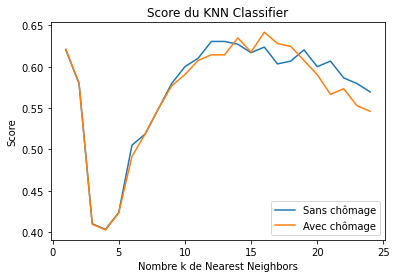

In [36]:
#KNN - jeu #1
(X_train, y_train, X_test, y_test) = (X_train1, y_train1, X_test1, y_test1)

score1 = []
for k in range(1,25):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    score_knn = knn.score(X_test, y_test)
    score1.append(score_knn)

#KNN - jeu #2
(X_train, y_train, X_test, y_test) = (X_train2, y_train2, X_test2, y_test2)

score2 = []
for k in range(1,25):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    score_knn = knn.score(X_test, y_test)
    score2.append(score_knn)
    

plt.plot(list(range(1,25)),score1, label="Sans chômage")
plt.plot(list(range(1,25)),score2, label="Avec chômage")
plt.title("Score du KNN Classifier")
plt.xlabel("Nombre k de Nearest Neighbors")
plt.ylabel("Score")
plt.legend();
# k = 15 ou 16 ex aequo

In [37]:
knn = KNeighborsClassifier(n_neighbors=16)
knn.fit(X_train1, y_train1)
y_pred_knn = knn.predict(X_test1)
score_knn = knn.score(X_test1, y_test1)
print(score_knn/score_base1)

knn = KNeighborsClassifier(n_neighbors=16)
knn.fit(X_train2, y_train2)
y_pred_knn = knn.predict(X_test2)
score_knn = knn.score(X_test2, y_test2)
print(score_knn/score_base2)

1.2689655172413794
1.2965517241379312


Interprétation : pour k très petit, le point le plus proche est certainement les valeurs du même département à une autre élection ??

On choisit k = 16.

In [38]:
#DecisionTree - jeu #1
(X_train, y_train, X_test, y_test) = (X_train1, y_train1, X_test1, y_test1)

score_gini1 = []
for k in range(1,50):
    tree = DecisionTreeClassifier(criterion='gini', max_depth=k,random_state=0)
    tree.fit(X_train, y_train)
    y_pred_tree = tree.predict(X_test)
    score_tree = tree.score(X_test, y_test)
    score_gini1.append(score_tree)
   # print(f"""k = {k}, Score : {score_knn}""")

score_entropy1 = []
for k in range(1,50):
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=k,random_state=1)
    tree.fit(X_train, y_train)
    y_pred_tree = tree.predict(X_test)
    score_tree = tree.score(X_test, y_test)
    score_entropy1.append(score_tree)
   # print(f"""k = {k}, Score : {score_knn}""")

#DecisionTree - jeu #2
(X_train, y_train, X_test, y_test) = (X_train2, y_train2, X_test2, y_test2)

score_gini2 = []
for k in range(1,50):
    tree = DecisionTreeClassifier(criterion='gini', max_depth=k,random_state=0)
    tree.fit(X_train, y_train)
    y_pred_tree = tree.predict(X_test)
    score_tree = tree.score(X_test, y_test)
    score_gini2.append(score_tree)
   # print(f"""k = {k}, Score : {score_knn}""")

score_entropy2 = []
for k in range(1,50):
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=k,random_state=1)
    tree.fit(X_train, y_train)
    y_pred_tree = tree.predict(X_test)
    score_tree = tree.score(X_test, y_test)
    score_entropy2.append(score_tree)
   # print(f"""k = {k}, Score : {score_knn}""")

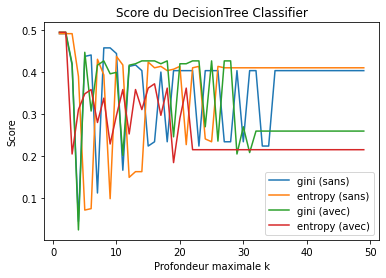

In [39]:
plt.plot(list(range(1,50)),score_gini1, label="gini (sans)")
plt.plot(list(range(1,50)),score_entropy1, label="entropy (sans)")
plt.plot(list(range(1,50)),score_gini2, label="gini (avec)")
plt.plot(list(range(1,50)),score_entropy2, label="entropy (avec)")
plt.title("Score du DecisionTree Classifier")
plt.xlabel("Profondeur maximale k")
plt.ylabel("Score")
plt.legend();

Les performances en Decision Tree sont toujours moins bonnes que la baseline. Cela s'explique bien "intuitivement" : on ne peut pas prendre les critères un à un, et se dire "celui-ci fait pencher la balance dans un sens, celui-ci dans un autre", puisque les critères sont un nombre important de départements, et un taux de croissance démographique normalisé.

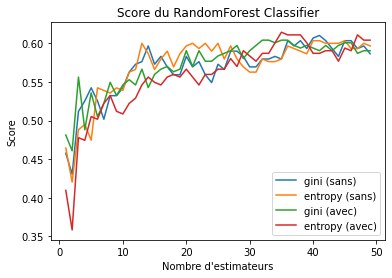

In [40]:
#RandomForest - jeu #1
(X_train, y_train, X_test, y_test) = (X_train1, y_train1, X_test1, y_test1)

score_gini1 = []
for k in range(1,50):
    rf = RandomForestClassifier(n_estimators=k,criterion="gini",random_state=0)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    score_rf = rf.score(X_test, y_test)
    score_gini1.append(score_rf)
   # print(f"""k = {k}, Score : {score_knn}""")

score_entropy1 = []
for k in range(1,50):
    rf = RandomForestClassifier(n_estimators=k,criterion="entropy",random_state=0)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    score_rf = rf.score(X_test, y_test)
    score_entropy1.append(score_rf)
    
#RandomForest - jeu #2
(X_train, y_train, X_test, y_test) = (X_train2, y_train2, X_test2, y_test2)

score_gini2 = []
for k in range(1,50):
    rf = RandomForestClassifier(n_estimators=k,criterion="gini",random_state=0)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    score_rf = rf.score(X_test, y_test)
    score_gini2.append(score_rf)
   # print(f"""k = {k}, Score : {score_knn}""")

score_entropy2 = []
for k in range(1,50):
    rf = RandomForestClassifier(n_estimators=k,criterion="entropy",random_state=0)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    score_rf = rf.score(X_test, y_test)
    score_entropy2.append(score_rf)

plt.plot(list(range(1,50)),score_gini1, label="gini (sans)")
plt.plot(list(range(1,50)),score_entropy1, label="entropy (sans)")
plt.plot(list(range(1,50)),score_gini2, label="gini (avec)")
plt.plot(list(range(1,50)),score_entropy2, label="entropy (avec)")
plt.title("Score du RandomForest Classifier")
plt.xlabel("Nombre d'estimateurs")
plt.ylabel("Score")
plt.legend();

In [41]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
#SVC - jeu #1
(X_train, y_train, X_test, y_test) = (X_train1, y_train1, X_test1, y_test1)
score_svc1 = []
for ker in kernels:     
    svc = SVC(kernel = ker)
    svc.fit(X_train, y_train)
    y_pred_svc = svc.predict(X_test)
    score_svc = svc.score(X_test, y_test)
    score_svc1.append(score_svc)
    
#SVC - jeu #1
(X_train, y_train, X_test, y_test) = (X_train2, y_train2, X_test2, y_test2)
score_svc2 = []
for ker in kernels:     
    svc = SVC(kernel = ker)
    svc.fit(X_train, y_train)
    y_pred_svc = svc.predict(X_test)
    score_svc = svc.score(X_test, y_test)
    score_svc2.append(score_svc)

In [42]:
df_svc = pd.DataFrame.from_records(data=(score_svc1, score_svc2), index=["Sans chômage", "Avec chômage"], 
                                   columns=kernels).T
print(df_svc.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Sans chômage &  Avec chômage \\
\midrule
linear  &      0.135593 &      0.153584 \\
poly    &      0.600000 &      0.593857 \\
rbf     &      0.593220 &      0.593857 \\
sigmoid &      0.505085 &      0.453925 \\
\bottomrule
\end{tabular}



In [43]:
print(0.600683/score_base1)
0.593857 /score_base2

1.2220792068965516


1.200000696551724

In [99]:
"""#Logistic Regression
score = []

for w in [None, 'balanced']:
    for a in []:
        lr = LogisticRegression(penalty='l1', class_weight=w, 
                                solver=a,max_iter=1000)
        lr.fit(X_train, y_train)
        y_pred_lr = lr.predict(X_train)
        score_lr = lr.score(X_test, y_test)
        score.append((w, penalty, score_lr))

print(score)"""

D:\Programmes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Programmes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Programmes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Programmes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Programmes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[(None, 'elasticnet', 0.23389830508474577), (None, 'elasticnet', 0.18305084745762712), (None, 'elasticnet', 0.17627118644067796), ('balanced', 'elasticnet', 0.19661016949152543), ('balanced', 'elasticnet', 0.16271186440677965), ('balanced', 'elasticnet', 0.3288135593220339)]


D:\Programmes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Visualisation

In [45]:
classes = {"A":0, "ED":1, "D":2, "C":3, "G":4, "EG":5}
classes

{'A': 0, 'ED': 1, 'D': 2, 'C': 3, 'G': 4, 'EG': 5}

In [48]:
#KNN

y_pred_knn = []
for (X_train, y_train, X_test, y_test) in [(X_train1, y_train1, X_test1, y_test1),
                                           (X_train2, y_train2, X_test2, y_test2)]:
    knn = KNeighborsClassifier(n_neighbors=16)
    knn.fit(X_train, y_train)
    y_pred_knn.append(knn.predict(X_test))

# jeu #1
res_knn1 = pd.DataFrame(df1[["Code du département","annee","election"]].iloc[idx_test1].copy())
res_knn1["Classification"] = y_pred_knn[0]
res_knn1['Classification'] = res_knn1['Classification'].apply(lambda x: classes[x])
res_knn1["elec"]= res_knn1["election"]+res_knn1["annee"]
res_knn1.drop(['annee','election'],axis=1, inplace=True)
elections = res_knn1["elec"].unique()

resultats = {}
for el in elections:
    df_viz1 = res_knn1.loc[res_knn1["elec"]==el].set_index(["Code du département"])["Classification"]
    resultats[el] = df_viz1.to_dict()
    fr_chart = pygal.maps.fr.Departments(human_readable=True)
    fr_chart.title = f'Classification par département (KNN, K=16), {el}'
    for nuance in classes.keys():
        fr_chart.add(nuance,{dep: resultats[el][dep] for dep in resultats[el].keys() if (resultats[el][dep] == classes[nuance])})
    fr_chart.render_to_png(f"images/knn_{el}_sans_chomage_map.png")
    
# jeu #2
res_knn2 = pd.DataFrame(df2[["Code du département","annee","election"]].iloc[idx_test2].copy())
res_knn2["Classification"] = y_pred_knn[1]
res_knn2['Classification'] = res_knn2['Classification'].apply(lambda x: classes[x])
res_knn2["elec"]= res_knn2["election"]+res_knn2["annee"]
res_knn2.drop(['annee','election'],axis=1, inplace=True)
elections = res_knn2["elec"].unique()

resultats = {}
for el in elections:
    df_viz2 = res_knn2.loc[res_knn2["elec"]==el].set_index(["Code du département"])["Classification"]
    resultats[el] = df_viz2.to_dict()
    fr_chart = pygal.maps.fr.Departments(human_readable=True)
    fr_chart.title = f'Classification par département (KNN, K=16), {el}'
    for nuance in classes.keys():
        fr_chart.add(nuance,{dep: resultats[el][dep] for dep in resultats[el].keys() if (resultats[el][dep] == classes[nuance])})
    fr_chart.render_to_png(f"images/knn_{el}_avec_chomage_map.png")

In [49]:
#SVC

y_pred_svc = []
for (X_train, y_train, X_test, y_test) in [(X_train1, y_train1, X_test1, y_test1),
                                           (X_train2, y_train2, X_test2, y_test2)]:
    svc = SVC(kernel = 'poly')
    svc.fit(X_train, y_train)
    y_pred_svc.append(svc.predict(X_test))
    
# jeu #1

res_svc = pd.DataFrame(df1[["Code du département","annee","election"]].iloc[idx_test1].copy())
res_svc["Classification"]=y_pred_svc[0]
res_svc['Classification'] = res_svc['Classification'].apply(lambda x: classes[x])
res_svc["elec"]= res_svc["election"]+res_svc["annee"]
res_svc.drop(['annee','election'],axis=1, inplace=True)

resultats = {}
for el in elections:
    df_viz3 = res_svc.loc[res_svc["elec"]==el].set_index(["Code du département"])["Classification"]
    resultats[el] = df_viz3.to_dict()
    fr_chart = pygal.maps.fr.Departments(human_readable=True)
    fr_chart.title = f'Classification par département (SVC à noyau polynomial), {el}'
    for nuance in classes.keys():
        fr_chart.add(nuance,{dep: resultats[el][dep] for dep in resultats[el].keys() if (resultats[el][dep] == classes[nuance])})
    fr_chart.render_to_png(f"images/svc_{el}_sans_chomage_map.png")
    
# jeu #2

res_svc = pd.DataFrame(df2[["Code du département","annee","election"]].iloc[idx_test2].copy())
res_svc["Classification"]=y_pred_svc[1]
res_svc['Classification'] = res_svc['Classification'].apply(lambda x: classes[x])
res_svc["elec"]= res_svc["election"]+res_svc["annee"]
res_svc.drop(['annee','election'],axis=1, inplace=True)

resultats = {}
for el in elections:
    df_viz4 = res_svc.loc[res_svc["elec"]==el].set_index(["Code du département"])["Classification"]
    resultats[el] = df_viz4.to_dict()
    fr_chart = pygal.maps.fr.Departments(human_readable=True)
    fr_chart.title = f'Classification par département (SVC à noyau polynomial), {el}'
    for nuance in classes.keys():
        fr_chart.add(nuance,{dep: resultats[el][dep] for dep in resultats[el].keys() if (resultats[el][dep] == classes[nuance])})
    fr_chart.render_to_png(f"images/svc_{el}_avec_chomage_map.png")

In [51]:
#RandomForest

# jeu #1
y_pred_rf = []

for (X_train, y_train, X_test, y_test) in [(X_train1, y_train1, X_test1, y_test1),
                                           (X_train2, y_train2, X_test2, y_test2)]:
    rf = RandomForestClassifier(n_estimators=34,criterion="entropy",random_state=0)
    rf.fit(X_train, y_train)
    y_pred_rf.append(rf.predict(X_test))

res_rf = pd.DataFrame(df1[["Code du département","annee","election"]].iloc[idx_test1].copy())
res_rf["Classification"]=y_pred_rf[0]
res_rf['Classification'] = res_rf['Classification'].apply(lambda x: classes[x])
res_rf["elec"]= res_rf["election"]+res_rf["annee"]
res_rf.drop(['annee','election'],axis=1, inplace=True)

resultats = {}
for el in elections:
    df_viz5 = res_rf.loc[res_rf["elec"]==el].set_index(["Code du département"])["Classification"]
    resultats[el] = df_viz5.to_dict()
    fr_chart = pygal.maps.fr.Departments(human_readable=True)
    fr_chart.title = f'Classification par département (RandomForest, 34 estimateurs, critère "entropy"), {el}'
    for nuance in classes.keys():
        fr_chart.add(nuance,{dep: resultats[el][dep] for dep in resultats[el].keys() if (resultats[el][dep] == classes[nuance])})
    fr_chart.render_to_png(f"images/rf_{el}_sans_chomage_map.png")
    
# jeu #2

res_rf = pd.DataFrame(df2[["Code du département","annee","election"]].iloc[idx_test2].copy())
res_rf["Classification"]=y_pred_rf[1]
res_rf['Classification'] = res_rf['Classification'].apply(lambda x: classes[x])
res_rf["elec"]= res_rf["election"]+res_rf["annee"]
res_rf.drop(['annee','election'],axis=1, inplace=True)

resultats = {}
for el in elections:
    df_viz6 = res_rf.loc[res_rf["elec"]==el].set_index(["Code du département"])["Classification"]
    resultats[el] = df_viz6.to_dict()
    fr_chart = pygal.maps.fr.Departments(human_readable=True)
    fr_chart.title = f'Classification par département (RandomForest, 34 estimateurs, critère "entropy"), {el}'
    for nuance in classes.keys():
        fr_chart.add(nuance,{dep: resultats[el][dep] for dep in resultats[el].keys() if (resultats[el][dep] == classes[nuance])})
    fr_chart.render_to_png(f"images/rf_{el}_avec_chomage_map.png")

In [67]:
data_tot.dtypes

Code du département     object
annee                   object
Votants                  int64
ABN                      int64
EG                     float64
G                      float64
C                      float64
D                      float64
ED                     float64
A                      float64
election                object
Population             float64
Populationdiff         float64
Nuance                  object
Taux_chomage           float64
dtype: object

In [71]:
# Carte de france tracée sur y_test

y_true = data_tot[["Code du département","annee","election","Nuance"]].loc[data_tot["annee"]>="2020"].copy()
y_true["Nuance"] = y_true['Nuance'].apply(lambda x: classes[x])
y_true["elec"]= y_true["election"]+y_true["annee"]
y_true.drop(['annee','election'],axis=1, inplace=True)
elections = y_true["elec"].unique()

resultats = {}
for el in elections:
    viz = y_true.loc[y_true["elec"]==el].set_index(["Code du département"])["Nuance"]
    resultats[el] = viz.to_dict()
    fr_chart = pygal.maps.fr.Departments(human_readable=True)
    fr_chart.title = f'Nuance majoritaire par département, {el}'
    for nuance in classes.keys():
        fr_chart.add(nuance,{dep: resultats[el][dep] for dep in resultats[el].keys() if (resultats[el][dep] == classes[nuance])})
    fr_chart.render_to_png(f"images/{el}_vraies_valeurs_map.png")